In [1]:
from collections import Counter
from linear_algebra import distance, vector_subtract, scalar_multiply
from functools import reduce
import math, random

import numpy as np
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
def sum_of_squares(v):
    """computes the sum of squared elements in v"""
    return sum(v_i ** 2 for v_i in v)

In [3]:
vector = [i for i in range(10)]
sum_of_squares(vector)

285

In [4]:
np.sum(np.square(vector))

285

In [5]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

In [6]:
def plot_estimated_derivative():
    def square(x):
        return x * x

    def derivative(x):
        return 2 * x

    derivative_estimate = lambda x: difference_quotient(square, x, h=0.00001)

    # plot to show they're basically the same
    x = range(-10,10)
    plt.plot(x, list(map(derivative, x)), 'rx')           # red  x
    plt.plot(x, list(map(derivative_estimate, x)), 'b+')  # blue +
    plt.show()                                      # purple *, hopefully

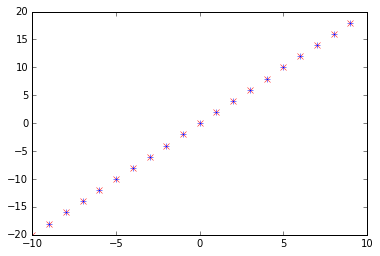

In [7]:
plot_estimated_derivative()

In [8]:
def partial_difference_quotient(f, v, i, h):

    # add h to just the i-th element of v
    w = [v_j + (h if j == i else 0)
         for j, v_j in enumerate(v)]

    return (f(w) - f(v)) / h

def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
            for i, _ in enumerate(v)]

In [9]:
def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]

def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f

In [10]:
print("using the gradient")
v = [random.randint(-10,10) for i in range(3)]
tolerance = 0.0000001

while True:
    #print v, sum_of_squares(v)
    gradient = sum_of_squares_gradient(v)   # compute the gradient at v
    next_v = step(v, gradient, -0.0001)       # take a negative gradient step
    if distance(next_v, v) < tolerance:     # stop if we're converging
        break
    v = next_v                              # continue if we're not

print("minimum v", v)
print("minimum value", sum_of_squares(v))
print()

using the gradient
minimum v [-0.0002810713051264979, 0.0003613773923055063, -0.00020076521794750227]
minimum value 2.4990137097254875e-07



In [11]:
#
#
# minimize / maximize batch
#
#

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]

        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)

In [12]:
print("using minimize_batch")
v = [random.randint(-10,10) for i in range(3)]
print (v)
v = minimize_batch(sum_of_squares, sum_of_squares_gradient, v)

print("minimum v", v)
print("minimum value", sum_of_squares(v))

using minimize_batch
[7, -7, 4]
minimum v [0.0009304595970494407, -0.0009304595970494407, 0.0005316911983139665]
minimum value 2.0142056538473567e-06


In [13]:
#
# minimize / maximize stochastic
#

def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

In [14]:
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = list(zip(x, y))
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

In [15]:
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                               negate_all(gradient_fn),
                               x, y, theta_0, alpha_0)

In [16]:
# Test를 위한 예제들은 이후 ch14 등에서 제시됨, 현재 코드만으로는 활용에 대해 이해하기 어려우니 skip 할 것을 추천

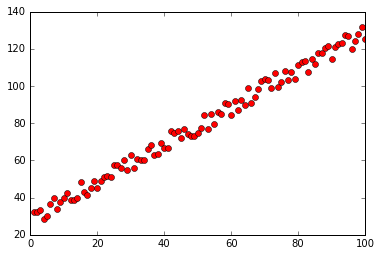

In [17]:
# Numpy version from : http://stackoverflow.com/questions/17784587/gradient-descent-using-python-and-numpy

def genData(numPoints, bias, variance):
    x = np.zeros(shape=(numPoints, 2))
    y = np.zeros(shape=numPoints)
    # basically a straight line
    for i in range(0, numPoints):
        # bias feature
        x[i][0] = 1
        x[i][1] = i
        # our target variable
        y[i] = (i+bias) + random.uniform(0, 1) * variance
    return x, y

# gen 100 points with a bias of 25 and 10 variance as a bit of noise
x, y = genData(100, 25, 10)

plt.plot(x[:,1]+1,y,"ro")
plt.show()

In [18]:
# m denotes the number of examples here, not the number of features
def gradientDescent(x, y, theta, alpha, m, numIterations):
    xTrans = x.transpose()
    theta_list = []
    for i in range(0, numIterations):
        hypothesis = np.dot(x, theta)
        loss = hypothesis - y
        
        # avg cost per example (the 2 in 2*m doesn't really matter here.
        # But to be consistent with the gradient, I include it)
        cost = np.sum(loss ** 2) / (2 * m)
        
        gradient = np.dot(xTrans, loss) / m
        # update
        theta = theta - alpha * gradient
        if i % 2500 == 0:
            theta_list.append(theta)
    return theta,np.array(theta_list)

m, n = np.shape(x)
numIterations= 50000
alpha = 0.0005
x.transpose()
theta = np.ones(n)
theta,theta_list = gradientDescent(x, y, theta, alpha, m, numIterations)

theta

array([ 29.22828174,   1.01274694])

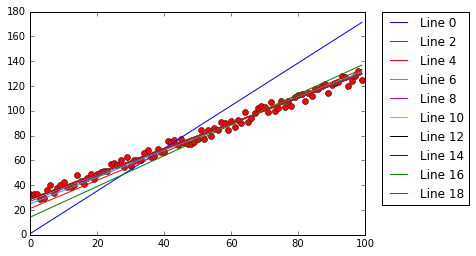

In [19]:
y_predict_step= np.dot(x, theta_list.transpose())
plt.plot(x[:,1],y,"ro")
for i in range (0,20,2):
    plt.plot(x[:,1],y_predict_step[:,i], label='Line %d'%i)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

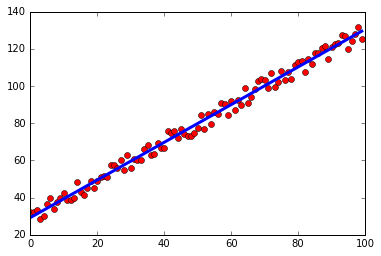

In [20]:
y_predict= np.dot(x, theta)

plt.plot(x[:,1],y,"ro")
plt.plot(x[:,1],y_predict, lw=3)